# Lab 3

Написати програмну реалiзацiю алгоритму лiнiйної фiльтрацiї зображень згорткою. Навести результати роботи вашої програми для наступних фiльтрiв:

- згортка зображень - це процес додавання кожного елемента зображення до його сусідів, зважених ядром. Важливо зауважити, що виконувана матрична операція - згортка - це не звичайне множення, хоча й позначається *.
- згортка - це процес транспонування рядків і стовпчиків ядра з наступним множенням і додаванням.

In [22]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


In [23]:
file_path = "before_3/lab1_foto2.png"
img = cv2.imread(file_path)

data = np.array(img)
data_list = img.tolist()

In [24]:
def apply_filter(image, kernel):
    image = np.array(image, dtype=np.float32)
    kernel = np.flip(kernel)  
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    result = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            result[i, j] = np.sum(region * kernel)

    return np.clip(result, 0, 255).astype(np.uint8)

#### Shifting

Зсув зображення на 10 пiкселiв вправо та 20 вниз.

In [25]:
def moving(data):
    a = 10
    b = 20
    result = np.zeros(data.shape, dtype=np.uint8)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            X_plus = x + a
            Y_plus = y + b
            if 0 <= X_plus < data.shape[1] and 0 <= Y_plus < data.shape[0]:
                result[Y_plus, X_plus] = data[y, x]
    return result


In [26]:
def moving_1(data):
    a = 10
    b = 20
    result = np.zeros_like(data)
    result[max(0, a):, max(0, b):] = data[:data.shape[0]-a, :data.shape[1]-b]
    return result

In [27]:
img_shift_2 = moving_1(img)
cv2.imwrite('./lab_3_foto/shifted_2_image.png', img_shift_2)

True

In [28]:
img_shift = moving(data)
cv2.imwrite('./lab_3_foto/shifted_image.png', img_shift)

True

#### Inversion


In [29]:
def inversion(data): # 3D list
    return [[[255 - k for k in j] for j in i] for i in data]  #row i, column -j, pixel value - k

In [30]:
def inversion_2(data):
    return 255 - data

In [31]:
def inversion_3(image):

    kernel = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 0]])  
    kernel = np.flipud(np.fliplr(kernel)) 


    output = np.zeros_like(image, dtype=np.float64)
    padded_image = np.pad(image, ((kernel.shape[0] // 2,), (kernel.shape[1] // 2,)), mode='constant', constant_values=0)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output.astype(np.uint8)

In [32]:
img_inverion = inversion(data_list)
img_inverion = np.array(img_inverion, dtype=np.uint8)
cv2.imwrite('./lab_3_foto/img_inverion.png', img_inverion)

img_inversion_2 = inversion_2(data)
cv2.imwrite('./lab_3_foto/img_inverion_2.png', img_inversion_2)

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 

img_inversion_3 = inversion_3(image)
cv2.imwrite('./lab_3_foto/img_inversion_3.png', img_inversion_3)


True

#### Gaussian smoothing

Gaussian density function - func dnirm (density norm) is used to calculate a Gaussian distibution

$$ \text{PDF}(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} $$

- x is the input value 

- μ is the mean 

- σ is the standard deviation, which controls the "spread" of the Gaussian function.

 Each element in the kernel represents the influence of that pixel on the center pixel, with closer pixels having a greater influence (higher weight) compared to those farther away.

одномерное ядро гауссового ядра (для смягчения краев и уменьшений шума, плавный переход цветов) для равноудаленных точек от центра
сума всех значений в этом ядре = 1 => нормализация

In [33]:
def dnorm(x, mean=0, std_dev=1):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

def gaussian_kernel(size, sigma=1, verbose=True):
    
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D /= kernel_2D.sum()  

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Gaussian Kernel")
        plt.colorbar()
        plt.show()
    return kernel_2D

def gaussian(image, kernel_s, sigma=1):

    kernel = gaussian_kernel(kernel_s, sigma)
    pad_size = kernel_s // 2  # свертка без выходя за предел массивааа
    
    result = np.zeros_like(image)

    for channel in range(image.shape[2]): 
        img_w_padd = np.pad(image[..., channel], ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = img_w_padd[i:i + kernel_s, j:j + kernel_s]
                result[i, j, channel] = np.sum(region * kernel)

    return result

In [34]:
def gaussian_2(image, kernel_size, sigma):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

In [35]:
gaussian_img_2 = gaussian_2(img, 11, sigma=1)
cv2.imwrite('./lab_3_foto/img_2_gaussian.png', gaussian_img_2)

True

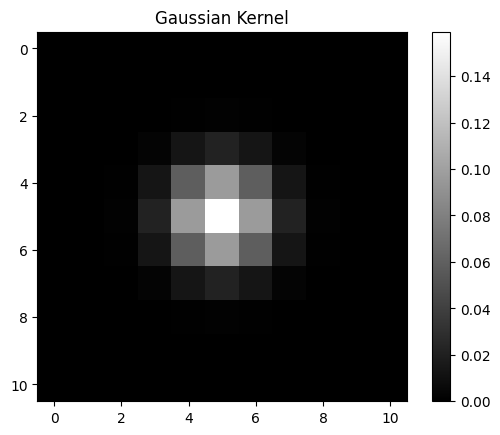

True

In [36]:
gaussian_img = gaussian(img, 11, sigma=1)
cv2.imwrite('./lab_3_foto/img_gaussian.png', gaussian_img)

#### Diagonal motion blur

(розмiр фiльтра не менше 7х7).

The motion blur kernel averages image pixels along the direction of motion that we would like to blur.

In [37]:
def diagonal_kernel(size):
    kernel = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        kernel[i, i] = 1.0  
    return kernel / size  

def diagonal_motion(image, kernel_size):
    
    kernel = diagonal_kernel(kernel_size)
    pad_size = kernel_size // 2
    blurred_image = np.zeros_like(image)

    for channel in range(image.shape[2]):  
        padded_image = np.pad(image[..., channel], ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size]
                blurred_image[i, j, channel] = np.sum(region * kernel)

    return blurred_image


In [38]:
def diagonal_motion_2(img, size=7):
    kernel = np.eye(size) / size
    return cv2.filter2D(img, -1, kernel)

In [39]:
img_diagonal_motion_2 = diagonal_motion_2(img, 8)
cv2.imwrite('./lab_3_foto/img_2_diagonal_motion.png', img_diagonal_motion_2)

True

In [40]:
img_diagonal_motion = diagonal_motion(img, 8)
cv2.imwrite('./lab_3_foto/img_diagonal_motion.png', img_diagonal_motion)

True

#### Sharpening

In [41]:

sharpen = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])
    
def sharpening(image, kernel):
    pad_size = kernel.shape[0] // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    convolved_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1], :]
            for c in range(3):  
                convolved_image[i, j, c] = np.clip(np.sum(region[:, :, c] * kernel), 0, 255)

    return convolved_image.astype(np.uint8)


In [42]:
sharpen_img = sharpening(img, sharpen)
cv2.imwrite('./lab_3_foto/sharpen_img.png', sharpen_img)

True

#### Sobel filter

The Sobel Edge Detector is a convolution-based method used for edge detection in images. It employs convolution with Sobel kernels to approximate the gradient of the image intensity. Instead of 2x2 kernels(it is used in Roberts Cross Detector), Sobel utilizes two 3x3 convolution kernels for detecting changes in intensity in the horizontal and vertical directions.

$$ \text{Magnitude} = \sqrt{(\text{grad}_x)^2 + (\text{grad}_y)^2} $$

In [43]:
def sobel_filter(image):

    gorizontal = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
    
    vertical = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]])

    height, width, _ = image.shape
    pad_size = 1
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    
    result = np.zeros((height, width, 3))

    for c in range(3):  
        for i in range(height):
            for j in range(width):
                
                region = padded_image[i:i + 3, j:j + 3, c]
                grad_x = np.sum(region * gorizontal)
                grad_y = np.sum(region * vertical)
                result[i, j, c] = np.clip(np.sqrt(grad_x**2 + grad_y**2), 0, 255)

    return result.astype(np.uint8)

In [44]:
sobel_result = sobel_filter(img)

# Save the result
cv2.imwrite('./lab_3_foto/img_sobel.png', sobel_result)

True

#### Borderi filter

In [45]:
def borderi_f(image):

    filter = np.array([[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]])
    
    height, width, _ = image.shape
    pad_size = 1
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    
    result = np.zeros_like(image)

    for c in range(3):  
        for i in range(height):
            for j in range(width):

                region = padded_image[i:i + 3, j:j + 3, c]
                result[i, j, c] = np.clip(np.sum(region * filter), 0, 255)

    return result.astype(np.uint8)

In [47]:
img_bord = borderi_f(img)
cv2.imwrite('./lab_3_foto/img_bord.png', img_bord)

True

#### Emboss filter

In [48]:
def emboss_f(image):
    matrix = np.array([[-1, -1, -1, -1,  0],
                           [-1, -1, -1,  0,  1],
                           [-1, -1,  0,  1,  1],
                           [-1,  0,  1,  1,  1],
                           [ 0,  1,  1,  1,  1]])
    height, width, _ = image.shape
    pad_size = matrix.shape[0] // 2

    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')

    filtered_image = np.zeros_like(image, dtype=np.float64)

    for i in range(height):
        
        for j in range(width):
            region = padded_image[i:i + 5, j:j + 5, :]
            for c in range(3):  
                filtered_image[i, j, c] = np.clip(np.sum(region[:, :, c] * matrix), 0, 255)

    return filtered_image.astype(np.uint8)


In [49]:
emboss_img = emboss_f(img)
cv2.imwrite('./lab_3_foto/emboss_img.png', emboss_img)

#### 